In [1]:
!rm -rf DS310_ViQA_Transformer
!git clone 'https://github.com/sonbui25/DS310_ViQA_Transformer.git'

Cloning into 'DS310_ViQA_Transformer'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 50 (delta 30), reused 33 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 44.21 KiB | 6.32 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [2]:
!pip install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer, DefaultDataCollator
import evaluate
import collections
import random

# Đường dẫn đến folder chứa dữ liệu
base_path = '/kaggle/input/viquad2-0'

2026-01-04 17:10:58.584900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767546658.769870      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767546658.822372      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767546659.265036      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767546659.265083      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767546659.265086      24 computation_placer.cc:177] computation placer alr

# Load data

In [4]:
def load_data_viquad(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    # Kiểm tra cấu trúc để đảm bảo an toàn
    if 'data' in raw_data and isinstance(raw_data['data'], list):
        # Trực tiếp chuyển list of dicts thành Dataset
        return Dataset.from_list(raw_data['data'])
    else:
        raise ValueError(f"File {file_path} không đúng định dạng mong đợi!")

# Load dữ liệu lại
print("Đang tải dữ liệu")
train_dataset = load_data_viquad(os.path.join(base_path, "train.json"))
valid_dataset = load_data_viquad(os.path.join(base_path, "dev.json"))

print(f"Đã tải xong.")
print(f"Kích thước tập Train: {len(train_dataset)}")
print(f"Kích thước tập Dev:   {len(valid_dataset)}")

# Xem lại mẫu dữ liệu
n_samples = 10
print(f"\n {n_samples} Mẫu dữ liệu đầu tiên:")
for i in range(min(n_samples, len(train_dataset))):
    sample = train_dataset[i]
    print(f"--- Sample {i+1} ---")
    print(json.dumps(sample, indent=2, ensure_ascii=False))

Đang tải dữ liệu
Đã tải xong.
Kích thước tập Train: 22765
Kích thước tập Dev:   5692

 10 Mẫu dữ liệu đầu tiên:
--- Sample 1 ---
{
  "id": "uit_000152",
  "context": "Sự hình thành của nội nhũ bắt đầu từ nhân nội nhũ. Sự phân chia của nó luôn luôn bắt đầu trước sự phân chia của tế bào trứng, và vì thế có sự chuẩn bị đúng lúc cho sự nuôi dưỡng phôi non. Nếu túi phôi hẹp thì sự hình thành của nội nhũ tiến hành trong khoảng các đường phân chia tế bào, nhưng trong các túi phôi rộng thì nội nhũ được hình thành trước mọi thứ như là một lớp tế bào trần trụi xung quanh tường bao của túi, và chỉ dần dần thu được đặc trưng của đa tế bào, tạo ra mô điền đầy túi phôi. Chức năng của nội nhũ chủ yếu là nuôi dưỡng phôi, và vị trí gốc của nó trong túi phôi được sắp xếp sao cho nó thích hợp nhất cho sự hấp thụ các chất dinh dưỡng của noãn. Thời gian tồn tại của nó thay đổi theo khả năng sớm phát triển của phôi. Nó có thể bị hấp thụ hoàn toàn bởi sự phát triển nhanh của phôi ngay từ trong túi phôi, hoặc

# EDA

--- Thống kê độ dài Context (tập Train) ---
Min: 88
Mean: 180.98
Max: 1537
95th Percentile: 315.00
99th Percentile: 405.00
------------------------------
--- Thống kê độ dài Answer (tập Train) ---
Min: 1
Mean: 9.99
Max: 150
95th Percentile: 31.00
99th Percentile: 48.00
------------------------------


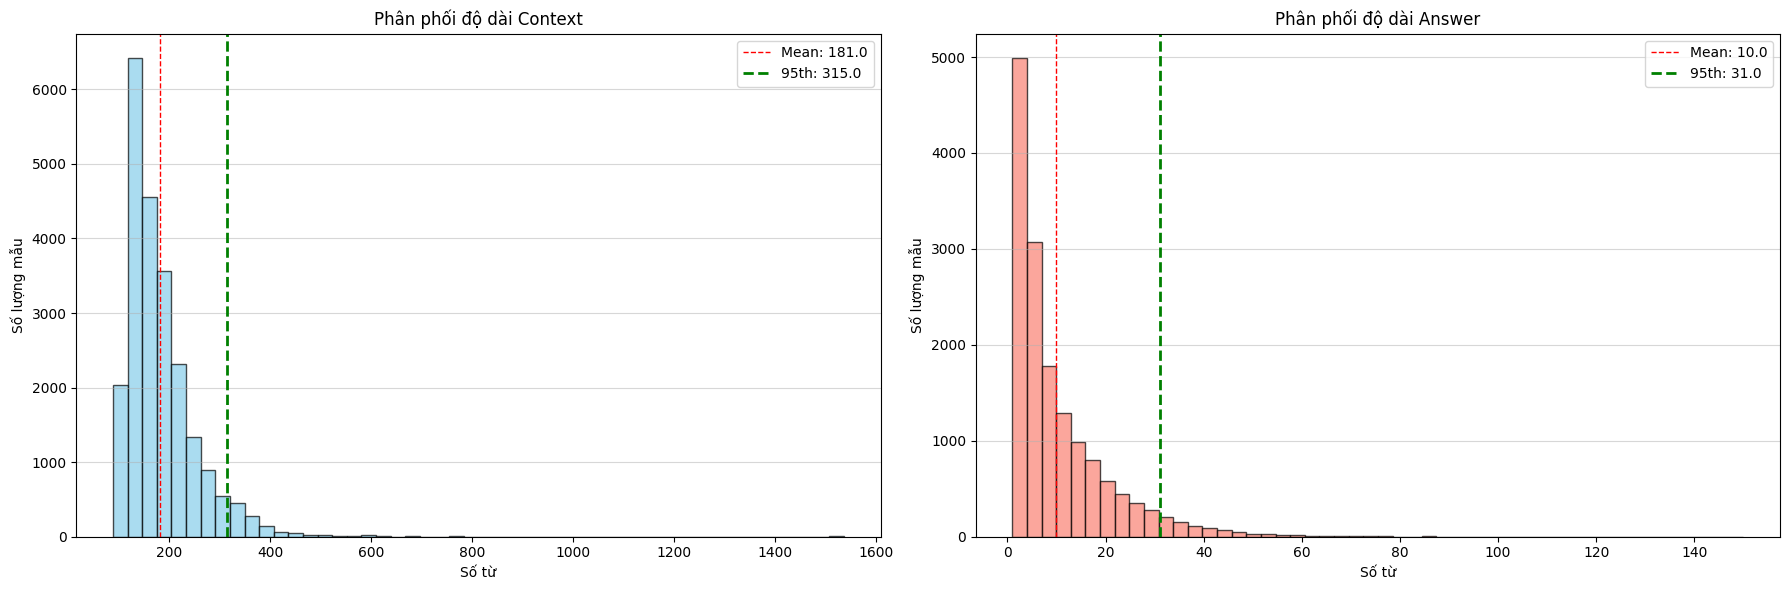

Selected MAX_LENGTH: 365


In [5]:
def analyze_data_lengths(dataset, dataset_name="Train"):
    """
    Phân tích và visualize thống kê độ dài của cả Context và Answer trong dataset.
    Trả về ngưỡng 95th percentile của Context để chọn max_length.
    """
    # 1. Trích xuất dữ liệu
    contexts = dataset['context']
    answers_list = dataset['answers'] # List các dict {'text': [...], 'answer_start': [...]}
    
    # 2. Tính độ dài (theo số từ - word count)
    context_lengths = [len(c.split()) for c in contexts]
    
    answer_lengths = []
    for ans in answers_list:
        # Một câu hỏi có thể có nhiều câu trả lời tham khảo, ta lấy tất cả
        for text in ans['text']:
            answer_lengths.append(len(text.split()))

    # Hàm phụ để in thống kê và vẽ lên trục (axes) cụ thể
    def plot_on_axis(lengths, title, ax, color):
        mean_len = np.mean(lengths)
        max_len = np.max(lengths)
        min_len = np.min(lengths)
        p95 = np.percentile(lengths, 95)
        p99 = np.percentile(lengths, 99)
        
        print(f"--- Thống kê độ dài {title} (tập {dataset_name}) ---")
        print(f"Min: {min_len}")
        print(f"Mean: {mean_len:.2f}")
        print(f"Max: {max_len}")
        print(f"95th Percentile: {p95:.2f}")
        print(f"99th Percentile: {p99:.2f}")
        print("-" * 30)

        # Vẽ Hist
        ax.hist(lengths, bins=50, color=color, edgecolor='black', alpha=0.7)
        ax.axvline(mean_len, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_len:.1f}')
        ax.axvline(p95, color='green', linestyle='dashed', linewidth=2, label=f'95th: {p95:.1f}')
        ax.set_title(f'Phân phối độ dài {title}')
        ax.set_xlabel('Số từ')
        ax.set_ylabel('Số lượng mẫu')
        ax.legend()
        ax.grid(axis='y', alpha=0.5)
        
        return int(p95)

    # 3. Khởi tạo khung vẽ (1 hàng, 2 cột)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Visualize Context (bên trái)
    p95_context = plot_on_axis(context_lengths, "Context", axes[0], 'skyblue')
    
    # Visualize Answer (bên phải)
    plot_on_axis(answer_lengths, "Answer", axes[1], 'salmon')
    
    plt.tight_layout()
    plt.show()
    
    return p95_context

# --- CÁCH GỌI HÀM MỚI ---
# truyền trực tiếp biến dataset (đã load ở bước trên) vào:
suggested_len = analyze_data_lengths(train_dataset, dataset_name="Train")

# Cập nhật MAX_LENGTH
MAX_LENGTH = min(suggested_len + 50, 512)
if MAX_LENGTH < 256: MAX_LENGTH = 256 
print(f"Selected MAX_LENGTH: {MAX_LENGTH}")

In [6]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
# Lấy key từ Secrets của Kaggle
wandb_api_key = user_secrets.get_secret("WANDB_API_KEY")

os.environ["WANDB_API_KEY"] = wandb_api_key
os.environ["WANDB_PROJECT"] = "BTTH3_NLP"

# Training vinai/phobert-base

In [7]:
### import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

!WANDB_MODE=online WANDB_DISABLED=false python /kaggle/working/DS310_ViQA_Transformer/question-answering/run_qa.py \
  --model_name_or_path vinai/phobert-base \
  --train_file /kaggle/input/viquad2-0/train.json \
  --validation_file /kaggle/input/viquad2-0/dev.json \
  --test_file /kaggle/input/viquad2-0/Private_Test_ref.json \
  --do_train \
  --do_eval \
  --do_predict \
  --version_2_with_negative \
  --per_device_train_batch_size 64 \
  --per_device_eval_batch_size 64 \
  --learning_rate 3e-5 \
  --num_train_epochs 15 \
  --max_seq_length 256 \
  --doc_stride 128 \
  --output_dir ./phobert-base-viquad \
  --save_total_limit 2 \
  --save_strategy epoch \
  --overwrite_output_dir \
  --overwrite_cache \
  --save_total_limit 1 \
  --load_best_model_at_end \
  --eval_strategy epoch \
  --save_strategy epoch \
  --metric_for_best_model eval_f1


2026-01-04 17:11:21.750464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767546681.772582      76 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767546681.779378      76 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767546681.796099      76 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767546681.796128      76 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767546681.796134      76 computation_placer.cc:177] computation placer alr

# Training google-bert/bert-base-multilingual-cased (mBERT)

In [8]:
### import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

!WANDB_MODE=online WANDB_DISABLED=false python /kaggle/working/DS310_ViQA_Transformer/question-answering/run_qa.py \
  --model_name_or_path google-bert/bert-base-multilingual-cased \
  --train_file /kaggle/input/viquad2-0/train.json \
  --validation_file /kaggle/input/viquad2-0/dev.json \
  --test_file /kaggle/input/viquad2-0/Private_Test_ref.json \
  --do_train \
  --do_eval \
  --do_predict \
  --version_2_with_negative \
  --per_device_train_batch_size 32 \
  --per_device_eval_batch_size 64 \
  --learning_rate 3e-5 \
  --num_train_epochs 15 \
  --max_seq_length 350 \
  --doc_stride 128 \
  --output_dir ./google-bert/bert-base-multilingual-cased-viquad \
  --save_strategy epoch \
  --overwrite_output_dir \
  --overwrite_cache \
  --save_total_limit 1 \
  --load_best_model_at_end \
  --eval_strategy epoch \
  --save_strategy epoch \
  --metric_for_best_model eval_f1

2026-01-04 20:45:30.199584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767559530.220478     182 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767559530.226831     182 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767559530.244453     182 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767559530.244482     182 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767559530.244489     182 computation_placer.cc:177] computation placer alr

# Training FacebookAI/xlm-roberta-base

In [9]:
### import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

!WANDB_MODE=online WANDB_DISABLED=false python /kaggle/working/DS310_ViQA_Transformer/question-answering/run_qa.py \
  --model_name_or_path FacebookAI/xlm-roberta-base \
  --train_file /kaggle/input/viquad2-0/train.json \
  --validation_file /kaggle/input/viquad2-0/dev.json \
  --test_file /kaggle/input/viquad2-0/Private_Test_ref.json \
  --do_train \
  --do_eval \
  --do_predict \
  --version_2_with_negative \
  --per_device_train_batch_size 32 \
  --per_device_eval_batch_size 64 \
  --learning_rate 3e-5 \
  --num_train_epochs 15 \
  --max_seq_length 350 \
  --doc_stride 128 \
  --output_dir ./FacebookAI/xlm-roberta-base-viquad \
  --save_strategy epoch \
  --overwrite_output_dir \
  --overwrite_cache \
  --save_total_limit 1 \
  --load_best_model_at_end \
  --eval_strategy epoch \
  --save_strategy epoch \
  --metric_for_best_model eval_f1

2026-01-05 00:56:30.282956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767574590.304268     279 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767574590.310659     279 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767574590.327096     279 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767574590.327125     279 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767574590.327130     279 computation_placer.cc:177] computation placer alr